## Links to files
- [welcome to the Duke Datathon 2024](https://colab.research.google.com/drive/1OsxF1EGvdl9ARSPUSLU2xn7MkDh2tCsJ#scrollTo=7pizABRCI3Cq) (this file)
  - [welcome - participants (Duke Datathon 2024)](https://colab.research.google.com/drive/1t7KvlLV44qezRXgRH_tKi-nb5InK7C-7)
  - [welcome - mentors]() (to be released)
- [Duke Datathon 2024 Frequently Asked Questions (FAQ)](https://docs.google.com/document/d/1eDas_wF7mxbRNJgplQvUMogD4fWupdxWWsaQ_tlckpU/edit)

## YouTube Videos
- [How to set up Physionet (MIMIC, eICU) for BigQuery](https://www.youtube.com/watch?v=N6fqg2QaNN8)
- [How to Register for GitHub (and get a GitHub ID)](https://youtu.be/uL5QCAmRbVI)
- [How to analyze PhysioNet EHR data with Jupyter/BigQuery](https://youtu.be/VDyw4ONIxMI)





# extracting data

## defines

In [1]:
%pip install tableone

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tableone
from google.colab import files
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


In [3]:
# change this to change the right project
%env GOOGLE_CLOUD_PROJECT = sccm-datathon-2023-participant

env: GOOGLE_CLOUD_PROJECT=sccm-datathon-2023-participant


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


total data

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project='dukedatathon2024')

query_notes = """
SELECT
    n.ROW_ID,
    n.TEXT
FROM `physionet-data.mimiciii_notes.noteevents` n
"""

# Execute the query for notes
query_job_notes = client.query(query_notes)
df_notes_whole = query_job_notes.to_dataframe()
len(df_notes_whole)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2083180

In [6]:
import pandas as pd
import re
def extract_section(text, start_keyword):
    """
    Extracts the section from the text starting with a keyword until a blank line or
    another major section header is detected.
    """
    # Convert to lowercase for case-insensitive matching, but work with original for extraction
    text_lower = text.lower()
    start_keyword = start_keyword.lower()

    try:
        start_index = text_lower.index(start_keyword) + len(start_keyword)
        # Find the end index by looking for two newline characters indicating a new section or end of the note
        end_index = text_lower.find('\n\n', start_index)
        if end_index == -1:  # If no double newline is found, take the rest of the text
            end_index = len(text)
        return text[start_index:end_index].strip()
    except ValueError:
        # Return None if the section isn't found
        return None

def clean_text(text):
    """
    Performs basic cleaning of text such as removing extra spaces, special characters, etc.
    """
    if text is not None:
        text = re.sub(r'\[\*\*.*?\*\*\]', '', text)  # Remove de-identified placeholders
        text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    return text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Define keywords to mark the start and end of the section of interest
# Define keywords to mark the start and end of the section of interest, maintain original case for matching
train_set_df = df_notes_df_testwhole
start_keyword = "Social History:"

# Extract and clean the Social History section from each row
train_set_df['processed_text'] = train_set_df['TEXT'].apply(
    lambda x: clean_text(extract_section(x, start_keyword))
)
# Count how many rows have None or missing 'processed_text'
missing_count = train_set_df['processed_text'].isnull().sum()

print(f"Number of records with missing 'Social History' sections: {missing_count}")

In [8]:
missing_count = train_set_df['processed_text'].isnull().sum()
print("Number of missing 'processed_text':", missing_count)

# Filter the DataFrame to find the first missing 'processed_text'
missing_example = train_set_df[train_set_df['processed_text'].isnull()].head(1)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of missing 'processed_text': 2021646
First missing example: ROW_ID                                                      1426629
TEXT              CCU Nursing Progress Note 11p-7a\nS: Pt remain...
processed_text                                                 None
Name: 0, dtype: object


In [10]:
missing_example.head(1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ROW_ID,TEXT,processed_text
0,1426629,CCU Nursing Progress Note 11p-7a\nS: Pt remain...,None


save the testing 70kdata


In [ ]:
# Calculate the number of words in each row of 'processed_text'
train_set_df['word_count'] = train_set_df['processed_text'].apply(lambda x: len(x.split()))

# Get descriptive statistics of the word count distribution
train_set_df['word_count'].describe()


In [24]:
df_test = train_set_df[train_set_df['processed_text'].notnull()][['ROW_ID', 'processed_text']]
df_test = df_test[df_test['processed_text'].notnull()]
df_test['word_count'] = df_test['processed_text'].apply(lambda x: len(x.split()))

# Get descriptive statistics of the word count distribution
df_test['word_count'].describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


count    61534.000000
mean       235.825316
std        384.360673
min          0.000000
25%         15.000000
50%         30.000000
75%        393.000000
max       2987.000000
Name: word_count, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


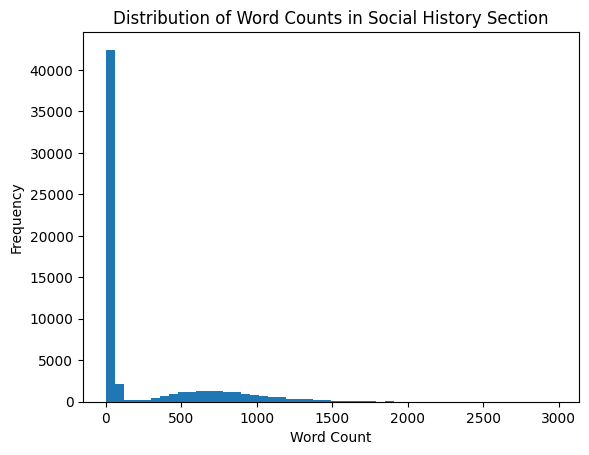

In [26]:
# prompt: df_test['word_count'] plot the distribution, drop the blank string of word count is 0

import matplotlib.pyplot as plt

# Filter out rows with word count of 0
df_test_filtered = df_test[df_test['word_count'] >0]

# Plot the distribution of word counts
df_test_filtered['word_count'].plot(kind='hist', bins=50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Social History Section')
plt.show()


In [13]:
# prompt: save the df_test

df_test.to_csv('df_test.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
patient_ids = df_test['ROW_ID'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## examples

In [ ]:

import pandas as pd


url = 'https://raw.githubusercontent.com/hibaahsan/MIMIC-SBDH/main/MIMIC-SBDH.csv'
df = pd.read_csv(url)

patient_ids = df['row_id'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# demongraphic fields

In [20]:
len(patient_ids)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


61534

In [38]:
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client(project='dukedatathon2024')

query = """
SELECT
    p.ROW_ID,
    p.GENDER,
    a.ETHNICITY,
    a.MARITAL_STATUS,
    a.INSURANCE,
    a.LANGUAGE,
    DATE_DIFF(DATE(a.ADMITTIME), DATE(p.DOB), YEAR) AS AGE,
FROM `physionet-data.mimiciii_notes.noteevents` n
JOIN `physionet-data.mimiciii_clinical.patients` p ON n.ROW_ID = p.ROW_ID
JOIN `physionet-data.mimiciii_clinical.admissions` a ON n.ROW_ID = a.ROW_ID
WHERE n.ROW_ID IN UNNEST(@ROW_ID)
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("ROW_ID", "INT64", patient_ids)
    ]
)

query_job = client.query(query, job_config=job_config)
df_notes_demographics = query_job.to_dataframe()

len(df_notes_demographics)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36775

In [39]:
# prompt: df_notes_demographics drop duplicate

df_notes_demographics = df_notes_demographics.drop_duplicates()
len(df_notes_demographics)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36775

In [27]:
patient_ids = df_notes_demographics['ROW_ID'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# prompt: have a new data match  the row_id in df_notes_demographics, and in df_test, i need keep all column df_test,  and all columns from df_notes_demographics

merged_df = pd.merge(df_test, df_notes_demographics, on='ROW_ID', how='right')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
merged_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ROW_ID,processed_text,word_count,GENDER,ETHNICITY,MARITAL_STATUS,INSURANCE,LANGUAGE,AGE
0,46006,"Lives at home with son, who is a teacher.Denie...",27,M,WHITE,LIFE PARTNER,Private,ENGL,66
1,39138,"Lives in , applying for a job and supposed to ...",20,M,WHITE,LIFE PARTNER,Medicare,ENGL,85
2,37775,"- Lives alone in an apartment. - Widowed, son ...",64,F,WHITE,LIFE PARTNER,Medicare,ENGL,38
3,46220,Lives at home and takes care of his sister. Di...,48,M,WHITE,LIFE PARTNER,Private,ENGL,70
4,36043,retired building info systems no tobacco ETOH:...,20,M,HISPANIC OR LATINO,LIFE PARTNER,Medicare,ENGL,145
...,...,...,...,...,...,...,...,...,...
36770,7575,The patient is married and lives on with his w...,30,F,WHITE,UNKNOWN (DEFAULT),Medicare,None,127
36771,16970,The patient lives with her husband and daughte...,16,F,UNKNOWN/NOT SPECIFIED,UNKNOWN (DEFAULT),Medicare,None,77
36772,36924,He is retired () from a clerical job with the ...,29,F,OTHER,UNKNOWN (DEFAULT),Medicare,ENGL,380
36773,493,"No tobacco, occasional alcohol, married",5,F,UNKNOWN/NOT SPECIFIED,UNKNOWN (DEFAULT),Medicare,None,-8


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


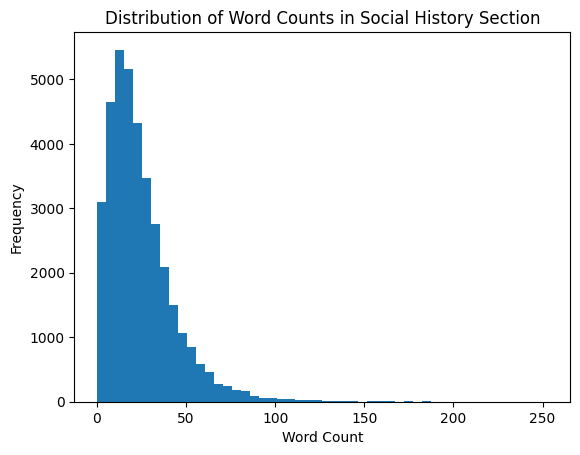

In [47]:

import matplotlib.pyplot as plt

# Filter out rows with word count of 0
df_test_filtered = merged_df[merged_df['word_count'] < 256]

# Plot the distribution of word counts
df_test_filtered['word_count'].plot(kind='hist', bins=50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Social History Section')
plt.show()


In [48]:
len(df_test_filtered)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36767

In [49]:
# prompt: save df_test_filtered in my drive

df_test_filtered.to_csv('/content/drive/MyDrive/df_test_filtered.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_notes_demographics

In [ ]:
query = """
SELECT
    p.SUBJECT_ID,  # Changed from p.ROW_ID for clarity, assuming you want the unique patient identifier
    p.GENDER,
    a.ETHNICITY,
    a.MARITAL_STATUS,
    a.INSURANCE,
    a.LANGUAGE,
    DATE_DIFF(DATE(a.ADMITTIME), DATE(p.DOB), YEAR) AS AGE
FROM `physionet-data.mimiciii_notes.noteevents` n
JOIN `physionet-data.mimiciii_clinical.patients` p ON n.SUBJECT_ID = p.SUBJECT_ID
JOIN `physionet-data.mimiciii_clinical.admissions` a ON n.SUBJECT_ID = a.SUBJECT_ID
WHERE a.LANGUAGE = 'ENGL'
"""

# Execute the query
query_job = client.query(query)  # No need for job_config since we're not using parameters here
df_all_patients_demographics = query_job.to_dataframe()


In [ ]:
df_notes_demographics.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ROW_ID,GENDER,ETHNICITY,MARITAL_STATUS,INSURANCE,LANGUAGE,AGE
0,28336,M,WHITE,WIDOWED,Medicare,ENGL,300
1,36621,F,OTHER,MARRIED,Medicare,ENGL,51
2,44156,M,WHITE,MARRIED,Medicare,ENGL,67
3,17133,M,WHITE,MARRIED,Private,ENGL,54
4,37037,M,WHITE,SINGLE,Medicaid,ENGL,51


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


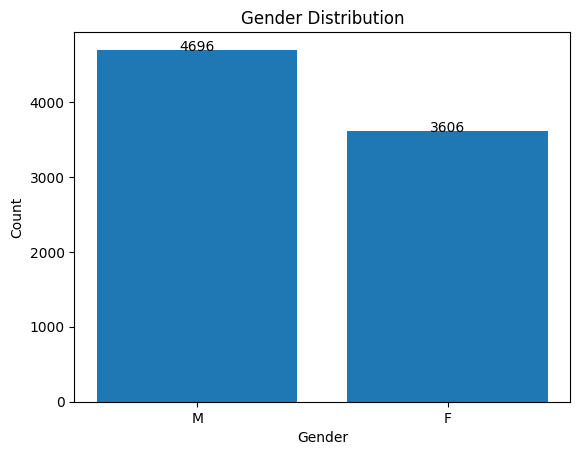

In [ ]:
# prompt: GENDER distrubution with label

import matplotlib.pyplot as plt

gender_counts = df_notes_demographics['GENDER'].value_counts()

fig, ax = plt.subplots()
ax.bar(gender_counts.index, gender_counts.values)
ax.set_xlabel('Gender')
ax.set_ylabel('Count')
ax.set_title('Gender Distribution')

# Add labels to the bars
for i, count in enumerate(gender_counts.values):
    ax.annotate(str(count), xy=(i, count - 50), ha='center', va='bottom')

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


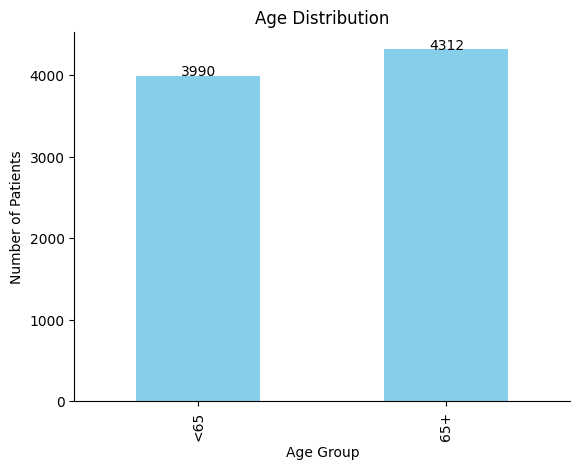

In [ ]:
# @title AGE

from matplotlib import pyplot as plt

# Define the age bins and labels
age_bins = [0,65,500]
age_labels = ['<=65','65+']

# Cut the age data into bins
df_notes_demographics['AgeGroup'] = pd.cut(df_notes_demographics['AGE'], bins=age_bins, labels=age_labels, right=False)

# Plotting the histogram from the binned data
age_group_counts = df_notes_demographics['AgeGroup'].value_counts(sort=False)
ax = age_group_counts.plot(kind='bar', color='skyblue', title='Age Distribution')

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labeling axes
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')

# Add text labels above the bars
for i, v in enumerate(age_group_counts):
    ax.text(i, v + 3, str(v), ha='center')

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


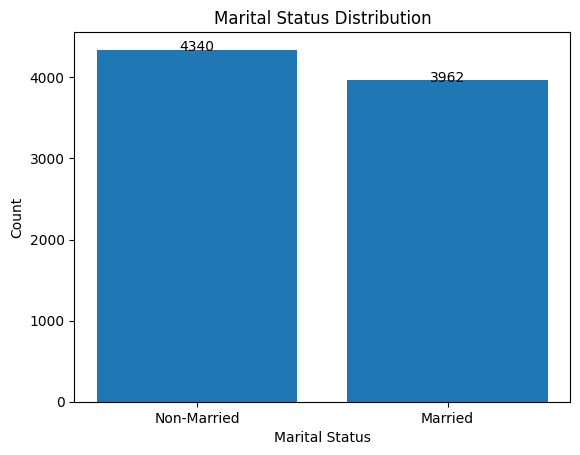

In [ ]:
# prompt: plot MARITAL_STATUS on married and non -marriad

marital_status_counts = df_notes_demographics['MARITAL_STATUS'].value_counts()

married_status = ['MARRIED','LIFE PARTNER' ]
non_married_status = ['SINGLE', 'UNKNOWN', 'WIDOWED', 'DIVORCED', 'SEPARATED']

df_notes_demographics['MaritalStatus'] = df_notes_demographics['MARITAL_STATUS'].apply(lambda x: 'Married' if x in married_status else 'Non-Married')

marital_status_counts = df_notes_demographics['MaritalStatus'].value_counts()

fig, ax = plt.subplots()
ax.bar(marital_status_counts.index, marital_status_counts.values)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.set_title('Marital Status Distribution')

# Add labels to the bars
for i, count in enumerate(marital_status_counts.values):
    ax.annotate(str(count), xy=(i, count - 50), ha='center', va='bottom')

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


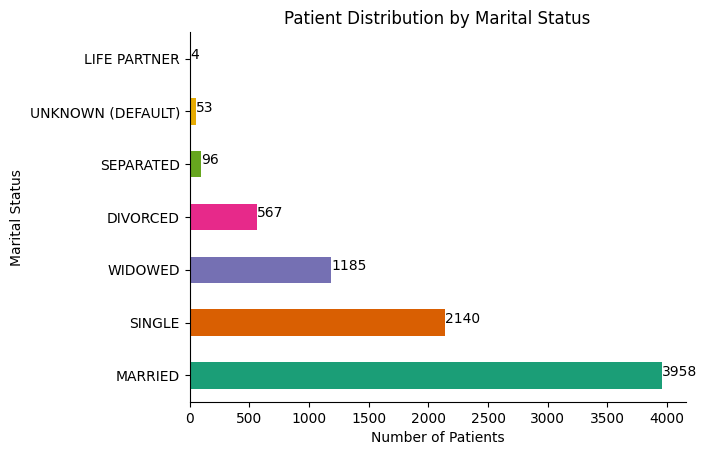

In [ ]:
# @title MARITAL_STATUS

from matplotlib import pyplot as plt
import seaborn as sns

# Calculating the counts of each marital status
marital_counts = df_notes_demographics['MARITAL_STATUS'].value_counts()

# Creating the bar plot with Seaborn's color palette
ax = marital_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Removing the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding the count annotation to each bar
for index, value in enumerate(marital_counts):
    plt.text(value, index, str(value))

# Setting a title and labels for clarity
plt.title('Patient Distribution by Marital Status')
plt.xlabel('Number of Patients')
plt.ylabel('Marital Status')

plt.show()


In [ ]:
df_notes_demographics.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['ROW_ID', 'GENDER', 'ETHNICITY', 'MARITAL_STATUS', 'INSURANCE',
       'LANGUAGE', 'AGE', 'AgeGroup'],
      dtype='object')

In [ ]:
ethnicity_counts

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ETHNICITY
WHITE                                         6599
BLACK/AFRICAN AMERICAN                        2042
HISPANIC OR LATINO                             150
OTHER                                          135
UNKNOWN/NOT SPECIFIED                          121
UNABLE TO OBTAIN                                73
PORTUGUESE                                      55
PATIENT DECLINED TO ANSWER                      42
ASIAN                                           39
HISPANIC/LATINO - PUERTO RICAN                  23
MULTI RACE ETHNICITY                            19
BLACK/AFRICAN                                   15
WHITE - OTHER EUROPEAN                          14
BLACK/HAITIAN                                   13
MIDDLE EASTERN                                  11
ASIAN - CHINESE                                 11
BLACK/CAPE VERDEAN                               8
ASIAN - ASIAN INDIAN                             6
WHITE - EASTERN EUROPEAN                         5
HISPANIC/LATINO - CEN

In [ ]:
ethnicity_mapping = {
    'WHITE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black/African American',
    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'OTHER': 'Other',
    'UNKNOWN/NOT SPECIFIED': 'Other',
    'UNABLE TO OBTAIN': 'Other',
    'PORTUGUESE': 'White',
    'PATIENT DECLINED TO ANSWER': 'Other',
    'ASIAN': 'Asian',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic/Latino',
    'MULTI RACE ETHNICITY': 'Other',
    'BLACK/AFRICAN': 'Black/African American',
    'WHITE - OTHER EUROPEAN': 'White',
    'BLACK/HAITIAN': 'Black/African American',
    'MIDDLE EASTERN': 'Other',
    'ASIAN - CHINESE': 'Asian',
    'BLACK/CAPE VERDEAN': 'Black/African American',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'WHITE - EASTERN EUROPEAN': 'White',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'Hispanic/Latino',
    'WHITE - RUSSIAN': 'White',
    'ASIAN - FILIPINO': 'Asian',
    'ASIAN - KOREAN': 'Asian',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Other',
    'CARIBBEAN ISLAND': 'Other',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic/Latino',
    'ASIAN - VIETNAMESE': 'Asian',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - CUBAN': 'Hispanic/Latino',
    'HISPANIC/LATINO - COLOMBIAN': 'Hispanic/Latino'
}
df_notes_demographics['Broad Ethnicity'] = df_notes_demographics['ETHNICITY'].map(ethnicity_mapping).fillna('Other')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


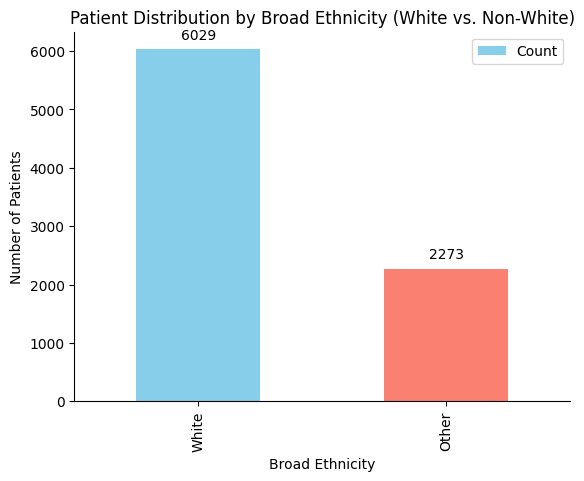

In [ ]:
# prompt: when plot Broad Ethnicity , only plot value white and other label non-white

# Group the data by Broad Ethnicity
grouped_data = df_notes_demographics.groupby('Broad Ethnicity')['Broad Ethnicity'].count()

# Filter out rows with 0 counts
filtered_data = grouped_data[grouped_data > 0]

# Create a new DataFrame with only "White" and "Other" categories
new_df = pd.DataFrame({'Broad Ethnicity': ['White', 'Other'], 'Count': [filtered_data['White'], filtered_data.drop('White').sum()]})

# Plot the bar chart
ax = new_df.plot(x='Broad Ethnicity', y='Count', kind='bar', color=['skyblue', 'salmon'])

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Broad Ethnicity')
plt.ylabel('Number of Patients')
plt.title('Patient Distribution by Broad Ethnicity (White vs. Non-White)')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


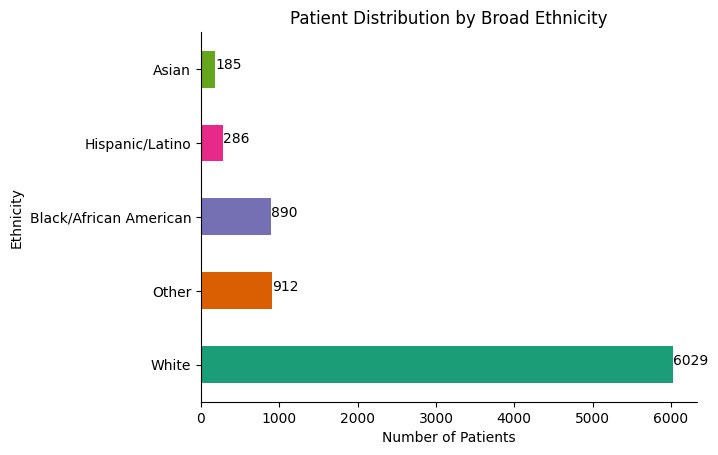

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Count the number of patients in each broad ethnicity group
ethnicity_counts = df_notes_demographics['Broad Ethnicity'].value_counts()

# Create the bar plot
ax = ethnicity_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add annotations for the count of each bar
for index, value in enumerate(ethnicity_counts):
    plt.text(value, index, str(value))

plt.title('Patient Distribution by Broad Ethnicity')
plt.xlabel('Number of Patients')
plt.ylabel('Ethnicity')
plt.show()

# white non white
# black non non black


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


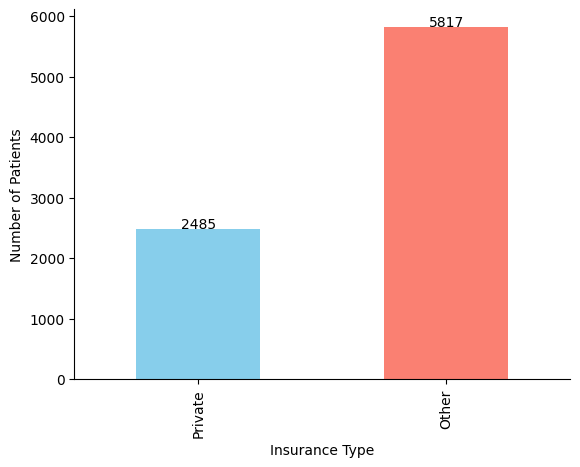

In [ ]:
# prompt: when plot INSURANCE , only plot value private and other lable non-private

insurance_counts = df_notes_demographics['INSURANCE'].value_counts()
insurance_counts_private = insurance_counts['Private']
insurance_counts_others = sum(insurance_counts[insurance_counts.index != 'Private'])

df_notes_demographics['INSURANCE'] = df_notes_demographics['INSURANCE'].apply(lambda x: 'Private' if x == 'Private' else 'Other')
ax = df_notes_demographics['INSURANCE'].value_counts(sort=False).plot(kind='bar', color=['skyblue', 'salmon'])

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labeling axes
plt.xlabel('Insurance Type')
plt.ylabel('Number of Patients')

for i, v in enumerate(df_notes_demographics['INSURANCE'].value_counts(sort=False)):
    ax.text(i, v + 3, str(v), ha='center')

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


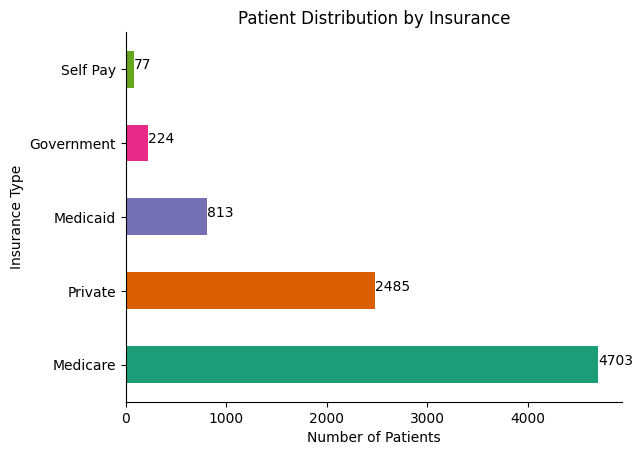

In [ ]:

# Calculate the counts of each insurance type
insurance_counts = df_notes_demographics['INSURANCE'].value_counts()

# Create the bar plot with Seaborn's color palette
ax = insurance_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add the count annotation to each bar
for index, value in enumerate(insurance_counts):
    plt.text(value, index, str(value))

# Set a title and labels for clarity
plt.title('Patient Distribution by Insurance')
plt.xlabel('Number of Patients')
plt.ylabel('Insurance Type')

plt.show()

# private
# other


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


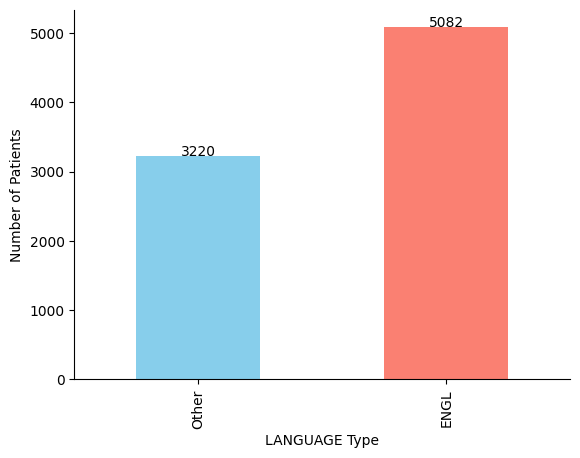

In [ ]:
insurance_counts = df_notes_demographics['LANGUAGE'].value_counts()
insurance_counts_private = insurance_counts['ENGL']
insurance_counts_others = sum(insurance_counts[insurance_counts.index != 'ENGL'])

df_notes_demographics['LANGUAGE'] = df_notes_demographics['LANGUAGE'].apply(lambda x: 'ENGL' if x == 'ENGL' else 'Other')
ax = df_notes_demographics['LANGUAGE'].value_counts(sort=False).plot(kind='bar', color=['skyblue', 'salmon'])

# Removing top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labeling axes
plt.xlabel('LANGUAGE Type')
plt.ylabel('Number of Patients')

for i, v in enumerate(df_notes_demographics['LANGUAGE'].value_counts(sort=False)):
    ax.text(i, v + 3, str(v), ha='center')

plt.show()

In [ ]:
df_notes_demographics['LANGUAGE'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LANGUAGE
ENGL    5082
SPAN     192
RUSS     140
PTUN      83
CANT      70
PORT      57
CAPE      46
HAIT      24
ITAL      20
GREE      14
VIET      14
MAND      13
AMER       9
CAMB       7
POLI       5
PERS       4
THAI       3
KORE       3
*YID       3
URDU       3
FREN       3
ALBA       2
HIND       2
*BUL       2
ARAB       2
*MAN       2
*BEN       1
SOMA       1
*FIL       1
JAPA       1
*TAM       1
*CHI       1
*GUJ       1
*AMH       1
*URD       1
*LIT       1
LAOT       1
**TO       1
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


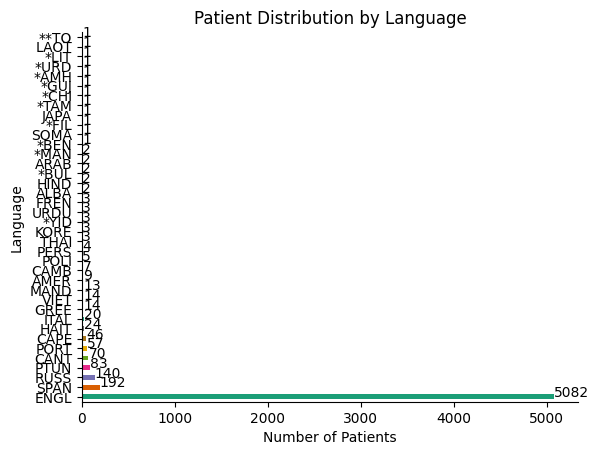

In [ ]:
# prompt: viz show LANGUAGE column

language_counts = df_notes_demographics['LANGUAGE'].value_counts()

# Create the bar plot with Seaborn's color palette
ax = language_counts.plot(kind='barh', color=sns.color_palette('Dark2'))

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add the count annotation to each bar
for index, value in enumerate(language_counts):
    plt.text(value, index, str(value))

# Set a title and labels for clarity
plt.title('Patient Distribution by Language')
plt.xlabel('Number of Patients')
plt.ylabel('Language')

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the DataFrame to a CSV file in Google Drive
df_notes_demographics.to_csv('/content/drive/My Drive/data/df_notes_demographics.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


training notes

In [ ]:
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client(project='dukedatathon2024')

# Assume patient_ids is already defined:
# patient_ids = df['row_id'].tolist()

# Configure query with parameters for secure and efficient querying
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("row_ids", "INT64", patient_ids)
    ]
)

# Execute the query and convert to DataFrame
query_job = client.query(query, job_config=job_config)
df_notes_demographics = query_job.to_dataframe()

# Display the DataFrame to see the results
print(df_notes_demographics)


In [28]:
from google.cloud import bigquery

client = bigquery.Client(project='dukedatathon2024')

query = """
SELECT ROW_ID, TEXT
FROM `physionet-data.mimiciii_notes.noteevents`
WHERE ROW_ID IN UNNEST(@ROW_ID)
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("ROW_ID", "INT64", patient_ids)
    ]
)

query_job = client.query(query, job_config=job_config)
df_notes = query_job.to_dataframe()

# df_notes.head()
# this is our training data
len(df_notes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


36775

In [29]:
# prompt: connect google drive and save df_notes in google drive

from google.colab import drive
drive.mount('/content/drive')

# Save the DataFrame to a CSV file in Google Drive
df_notes.to_csv('/content/drive/My Drive/df_test.csv')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [ ]:
%%bigquery --project dukedatathon2024
SELECT *
FROM `physionet-data.mimiciii_clinical.patients`
LIMIT 1


Query is running:   0%|          |

Downloading:   0%|          |

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,49,56,F,1804-01-02,2104-01-08,2104-01-08,2104-01-08,1


In [ ]:
retrieved_ids = set(df_notes['ROW_ID'].tolist())


original_ids = set(patient_ids)

missing_ids = original_ids - retrieved_ids

print("Missing ROW_IDs:", missing_ids)

Missing ROW_IDs: set()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(df_notes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7025